In [44]:
import pickle
import numpy as np
from matplotlib import pyplot as plt
import plotly.express as px
from scipy.signal import correlate2d, convolve2d
from scipy.ndimage import maximum_filter
import glob
import tqdm
import cv2

import torch
import torch.nn.functional as F

In [2]:
def get_peaks_torch(heatmap, kernel=3, k=6):
    heatmap = torch.from_numpy(heatmap)
    pad = (kernel - 1) // 2
    hmax = F.max_pool2d(heatmap, kernel, stride=1, padding=pad)
    keep = (hmax == heatmap).float()
    local_max = heatmap * keep
    
    batch, num_points, height, width = local_max.size()
    topk_scores, topk_inds = torch.topk(local_max.view(batch, num_points, -1), k)
    topk_inds = topk_inds % (height * width)
    topk_ys = torch.div(topk_inds, width, rounding_mode='floor')
    topk_xs = (topk_inds % width).int().float()
    return local_max, topk_scores, topk_inds, topk_ys, topk_xs

def get_peaks_var(heatmap, score_filter=0.1):
    local_max, topk_scores, topk_inds, topk_ys, topk_xs = get_peaks_torch(heatmap)
    topk_scores_np = topk_scores.numpy()
    topk_scores_filter = topk_scores_np > score_filter
    peaks_var = np.nanvar(topk_scores_np, axis=2, where=topk_scores_filter)
    peaks_var[topk_scores_filter.sum(axis=2) > 1] = 1-peaks_var[topk_scores_filter.sum(axis=2) > 1]
    return np.nan_to_num(peaks_var), topk_scores_filter.sum(axis=2), topk_scores_np

In [3]:
all_heatmap_files = glob.glob("data/output/heatmap/*.pkl")

In [9]:
# all_heatmaps = {}
# for filepath in tqdm.notebook.tqdm_notebook(all_heatmap_files):
#     with open(filepath, "rb") as f:
#         heatmap = pickle.load(f)
#         for class_heatmap in heatmap:
#             class_id = class_heatmap['class_id']
#             if class_id in all_heatmaps:
#                 all_heatmaps[class_id] = np.concatenate(
#                     [all_heatmaps[class_id], class_heatmap['heatmap']]
#                     , axis=0)
#             else:
#                 all_heatmaps[class_id] = class_heatmap['heatmap']
# with open("data/output/all_heatmaps.pkl", "wb") as f:
#     pickle.dump(all_heatmaps, f)
with open("data/output/all_heatmaps.pkl", "rb") as f:
    all_heatmaps = pickle.load(f)

  0%|          | 0/5833 [00:00<?, ?it/s]

In [12]:
peaks_var_0, peaks_count_0, topk_scores_0 = get_peaks_var(all_heatmaps[0])
peaks_var_8, peaks_count_8, topk_scores_8 = get_peaks_var(all_heatmaps[8])

/tmp/ipykernel_168706/2959741480.py:19: RuntimeWarning: Degrees of freedom <= 0 for slice.
  peaks_var = np.nanvar(topk_scores_np, axis=2, where=topk_scores_filter)


In [14]:
peaks_count_0.mean(axis=0)

array([1.36926148, 1.37952666, 1.42543484, 1.30938124, 1.33846593,
       1.31194753, 1.39606501, 1.34245794])

In [15]:
peaks_count_8.mean(axis=0)

array([1.45676647, 1.42586826, 1.37964072, 1.56838323, 1.05652695,
       1.01508982])

In [16]:
peaks_var_0.mean(axis=0, where=peaks_count_0 > 1)

array([0.9452735 , 0.9479886 , 0.931184  , 0.91423124, 0.9657887 ,
       0.9702623 , 0.9495728 , 0.9483341 ], dtype=float32)

In [17]:
peaks_var_8.mean(axis=0, where=peaks_count_8 > 1)

array([0.97679895, 0.9784011 , 0.97524345, 0.9735066 , 0.9106504 ,
       0.95032305], dtype=float32)

In [18]:
((topk_scores_0 > 0.3).sum(axis=2) > 1).mean(axis=0)

array([0.07927003, 0.09580838, 0.06814942, 0.07271172, 0.11063587,
       0.13202167, 0.16224693, 0.15854006])

In [19]:
(topk_scores_0 > 0.3).sum(axis=2).mean(axis=0)

array([1.01055033, 1.03051041, 0.97205589, 0.96863416, 1.0499002 ,
       1.04562304, 1.13031081, 1.11804962])

In [20]:
(topk_scores_8 > 0.3).sum(axis=2).mean(axis=0)

array([1.12862275, 1.10299401, 1.0411976 , 1.14658683, 0.90491018,
       0.8960479 ])

In [21]:
((topk_scores_8 > 0.3).sum(axis=2) > 1).mean(axis=0)

array([0.2205988 , 0.20263473, 0.15592814, 0.23760479, 0.05796407,
       0.04215569])

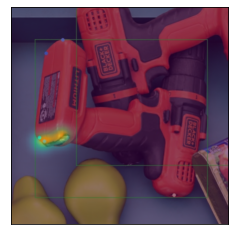

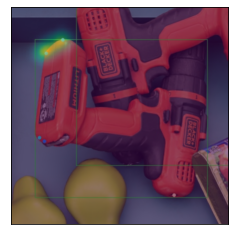

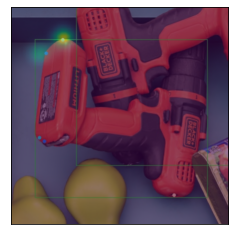

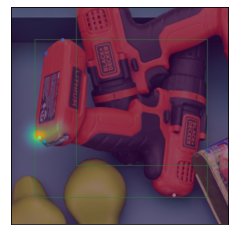

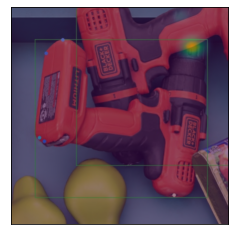

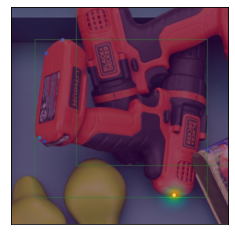

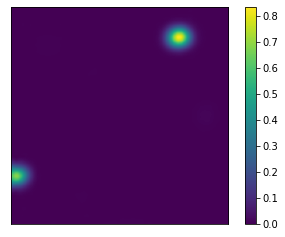

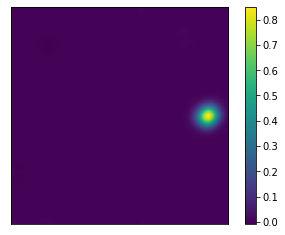

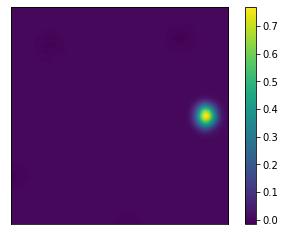

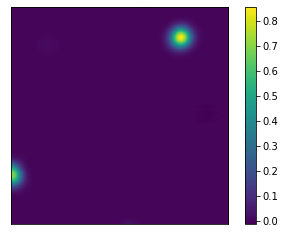

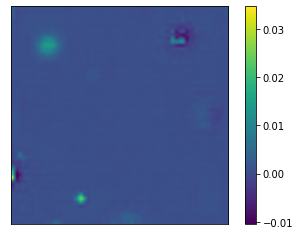

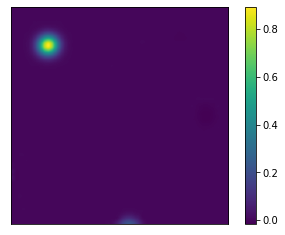

In [62]:
with open("data/output/heatmap/vis_heatmap_8949.pkl", "rb") as f:
    heatmap = pickle.load(f)
cropped_img = plt.imread("8949_1_crop.png")
for i in range(6):
#     plt.figure(figsize=(10, 10))
    plt.imshow(cropped_img)
    plt.imshow(
        cv2.resize(heatmap[0]['heatmap'][1, i, :, :], dsize=cropped_img.shape[:2], interpolation=cv2.INTER_CUBIC)
        , alpha=0.5)
    plt.xticks([])
    plt.yticks([])
#     plt.savefig(f"8949_1_heatmap_{i}.png")
    plt.show()

for i in range(6):
#     plt.figure(figsize=(10, 10))
#     plt.imshow(cropped_img)
    plt.imshow(
        cv2.resize(heatmap[0]['heatmap'][0, i, :, :], dsize=cropped_img.shape[:2], interpolation=cv2.INTER_CUBIC)
        , alpha=1)
    plt.xticks([])
    plt.yticks([])
    plt.colorbar()
#     plt.savefig(f"8949_1_heatmap_{i}.png")
    plt.show()

In [64]:
with open("data/output/heatmap/vis_heatmap_24115.pkl", "rb") as f:
    heatmap = pickle.load(f)

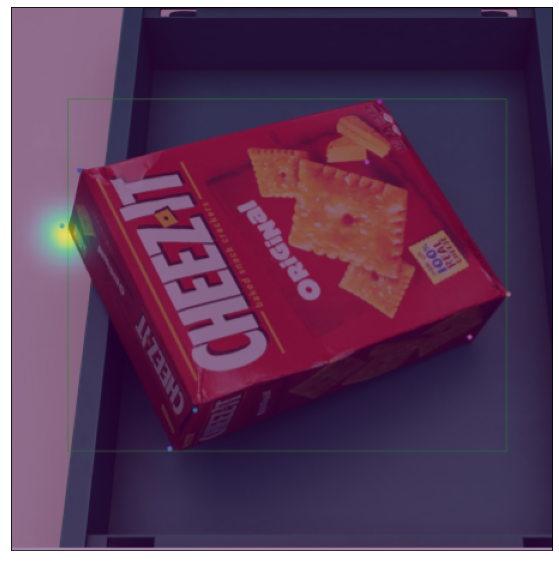

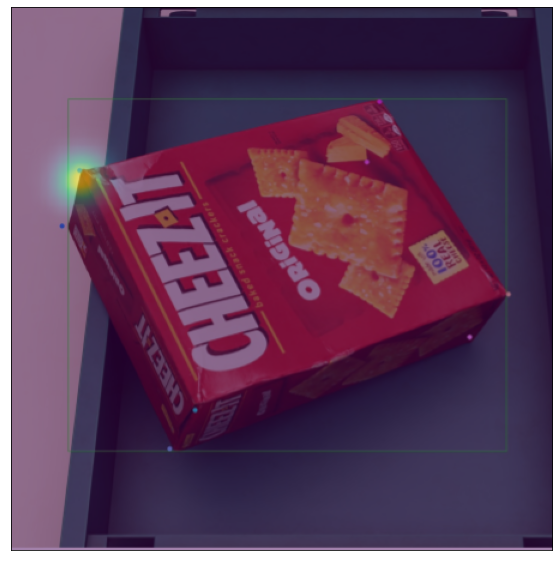

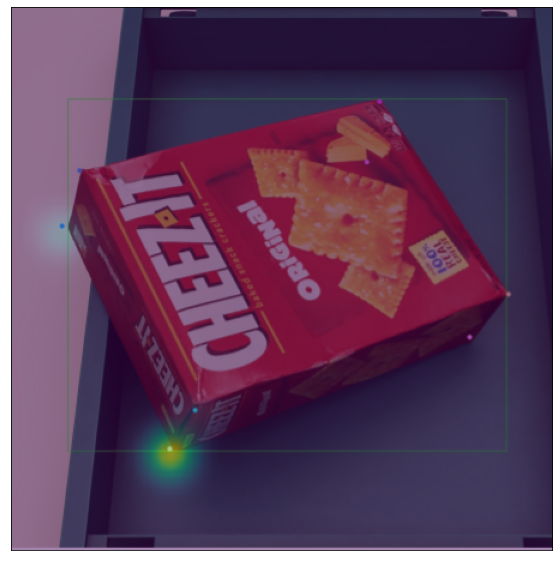

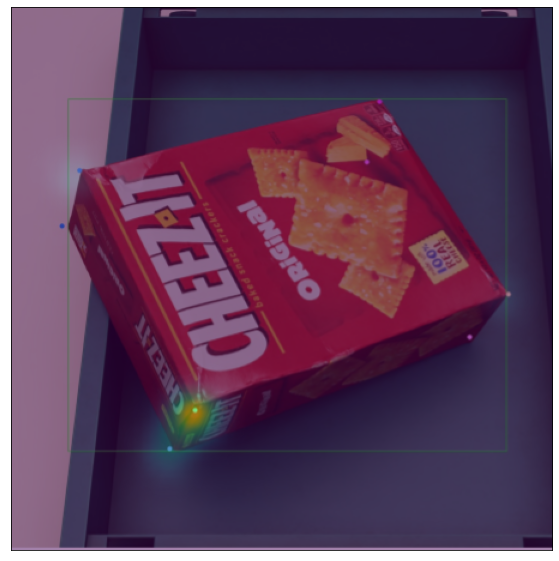

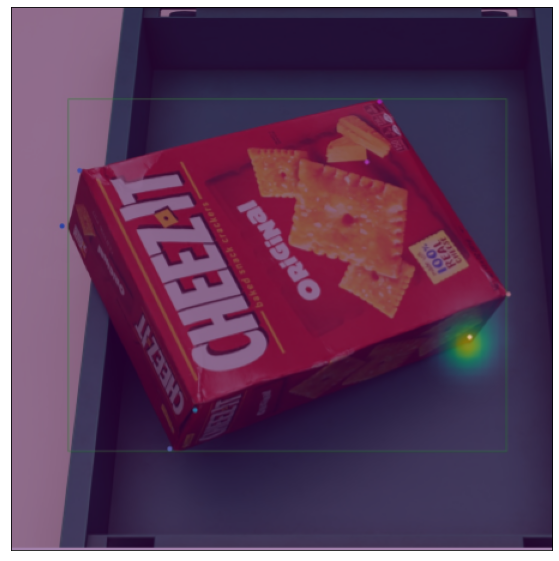

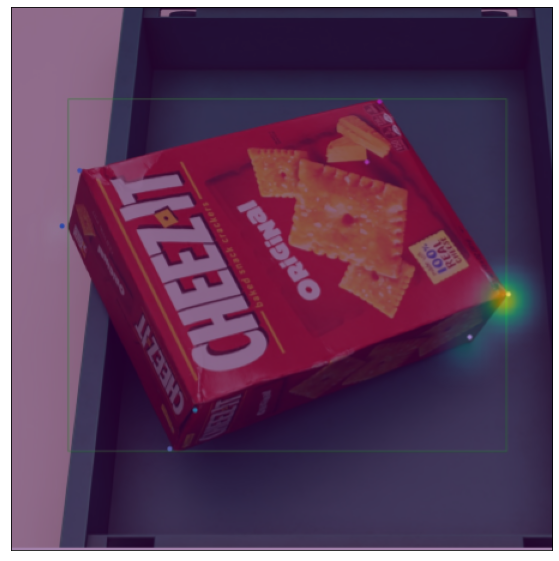

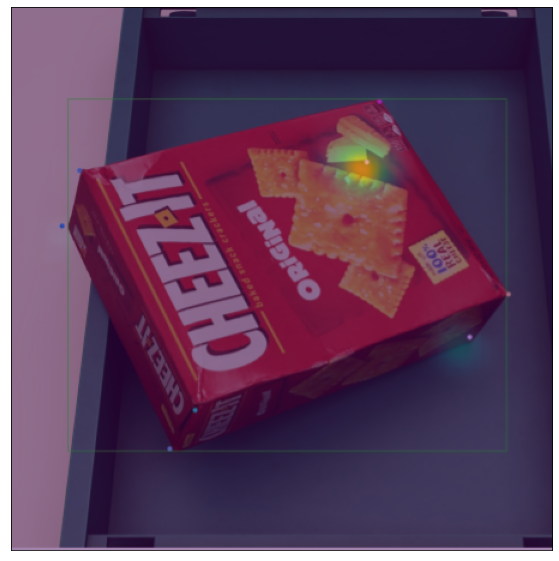

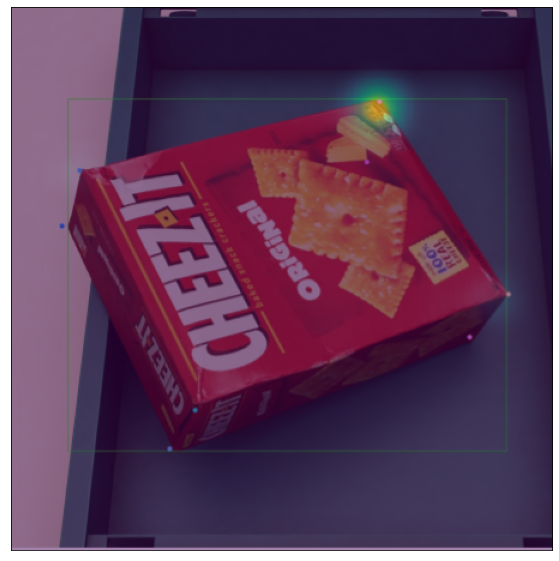

In [65]:
cropped_img = plt.imread("24115_0_crop.png")
for i in range(8):
    plt.figure(figsize=(10, 10))
    plt.imshow(cropped_img)
    plt.imshow(
        cv2.resize(heatmap[0]['heatmap'][0, i, :, :], dsize=cropped_img.shape[:2], interpolation=cv2.INTER_CUBIC)
        , alpha=0.5)
    plt.xticks([])
    plt.yticks([])
    plt.savefig(f"24115_0_heatmap_{i}.png")
    plt.show()

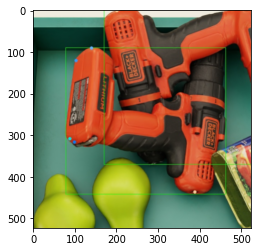